# Replicate QST article sims

### 1. Mesolve approach

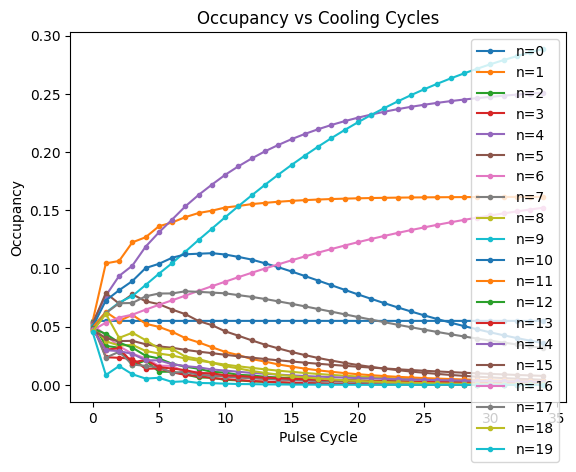

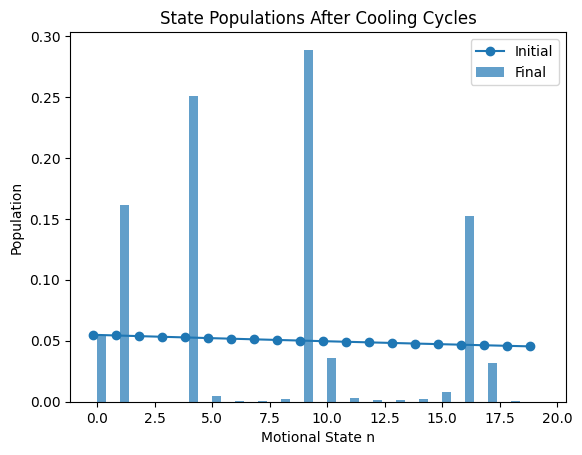

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0.005  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
tg = 200 # Dissipation duration (time gap)

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Hamiltonian (Red Sideband for Pulse)
H_pulse = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)
# Hamiltonian (Free evolution for Dissipation) - Assuming H0 during dissipation phase? 
# For now, let's assume H_diss = 0 for the dissipative step relative to the rotating frame.
H_diss = gamma * s_z_full 

# --- Collapse Operators for Dissipation ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
G = gamma / 2 

c_ops = []
for i, c in enumerate(cosal):
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    c_ops.append(np.sqrt(2 * G * W[i]) * op)

# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 34 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

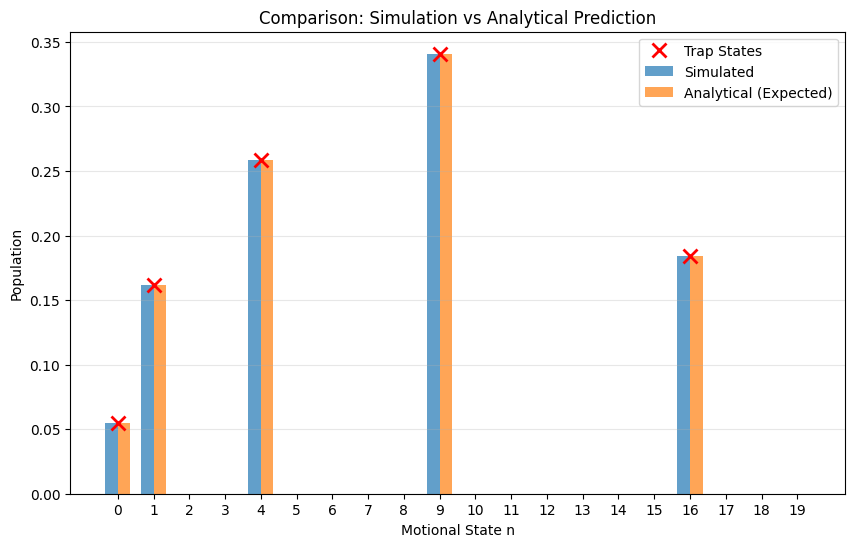

Trap State Populations:
State n    Simulated       Analytical      Diff           
0          0.0549          0.0549          0.0000
1          0.1615          0.1614          0.0001
4          0.2588          0.2585          0.0003
9          0.3407          0.3409          -0.0001
16         0.1840          0.1843          -0.0004


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0.005  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration
tg = 200 # Dissipation duration (time gap)

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))

# Hamiltonian (Red Sideband for Pulse)
H_pulse = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)
# Hamiltonian (Free evolution for Dissipation) - Assuming H0 during dissipation phase? 
# For now, let's assume H_diss = 0 for the dissipative step relative to the rotating frame.
H_diss = gamma * s_z_full 

# --- Collapse Operators for Dissipation ---
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)
G = gamma / 2 

c_ops = []
for i, c in enumerate(cosal):
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    c_ops.append(np.sqrt(2 * G * W[i]) * op)

# --- Construct Liouvillians ---
# 1. Pulse Step: Coherent RSB drive, NO dissipation (or minimal?)
# Typically only Unitary part active during pulse
L_pulse = liouvillian(H_pulse, []) 

# 2. Dissipation Step: No Drive, ONLY Dissipation (Optical Pumping)
# H = 0 (or H0), c_ops active
L_diss = liouvillian(H_diss, c_ops)

# --- Propagators ---
# Propagator for Pulse step (duration tau)
prop_pulse = (L_pulse * tau).expm()

# Propagator for Dissipation step (duration tg)
prop_diss = (L_diss * tg).expm()

# Combined Propagator for one cycle (Pulse -> Dissipation)
prop_cycle = prop_diss * prop_pulse 


# --- Simulation ---
num_pulses = 34 # Number of cycles
times_sim = np.arange(num_pulses + 1) # Just integer steps for cycles

# Initial state
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr() 
ground_state = basis(2, 1) 
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Storage
occupancies = np.zeros((num_pulses + 1, N))
rho_vec = operator_to_vector(initial_state)

# Initial occupancy
rho_mat = vector_to_operator(rho_vec)
occupancies[0, :] = rho_mat.ptrace(1).diag().real

# Evolve step-by-step
current_rho_vec = rho_vec
for k in range(1, num_pulses + 1):
    current_rho_vec = prop_cycle * current_rho_vec
    
    # Store
    rho_mat = vector_to_operator(current_rho_vec)
    occupancies[k, :] = rho_mat.ptrace(1).diag().real


# Plot the occupancy of all motional states over cycles
plt.figure()
for n in range(N):
    plt.plot(times_sim, occupancies[:, n], '.-', label=f'n={n}')
plt.xlabel('Pulse Cycle')
plt.ylabel('Occupancy')
plt.title('Occupancy vs Cooling Cycles')
plt.legend()
plt.show()

# Bar plot
p_motional_initial = occupancies[0, :]
p_motional_final = occupancies[-1, :]
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('State Populations After Cooling Cycles')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Define system parameters
Delta = 1.0  # Detuning
nu = 1.0     # Motional frequency
Omega=.01  # Rabi frequency
eta = 0.02    # Lamb-Dicke parameter
n_thermal = 1  # Average thermal phonon number
n0 = 1
gamma = 0.005  # Spin relaxation
beta = 0.01    # Inverse temperature
kT = 1.0      # Boltzmann constant times temperature
tau = 2 * np.pi / (eta * Omega * np.sqrt(n0))  # Pulse duration

# Define operators
N = 20  # Truncation for the Fock space

# QHO operators
a = destroy(N)  # Annihilation operator
a_dag = a.dag()  # Creation operator
xop = a + a_dag # Position operator

# Spin operators
sz = sigmaz()
s_plus = sigmap()
s_minus = sigmam()

# Displacement operator
D_eta = displace(N, (1j * eta)/2)
D_eta_full = tensor(qeye(2), D_eta)

# Full size operators
s_z_full = tensor(sz, qeye(N))
s_plus_full = tensor(s_plus, qeye(N))
a_full = tensor(qeye(2), a)
a_dag_full = tensor(qeye(2), a_dag)
s_minus_full = tensor(s_minus, qeye(N))
s_y_full = tensor(sigmay(), qeye(N))
s_x_full = tensor(sigmax(), qeye(N))

# Hamiltonian (Red Sideband)
H = 1j*eta*Omega/2 * (a_full* s_plus_full - a_dag_full * s_minus_full)

print(tau)

# Calculate weights for recoil
cosmax = 100
cosal = np.arange(-cosmax, cosmax + 1) / cosmax
W = 3 * (cosal**2 + 1) / 4 * 1 / (2 * cosmax)
W = W / sum(W)

# Coupling parameter G
# In your equation: 2*G*carrier -> Term is 2G * (C rho C†)
# Standard Lindblad: gamma * (C rho C†) -> So effective gamma is 2G
G = gamma / 2 

# Construct Collapse Operators
c_ops = []
for i, c in enumerate(cosal):
    # Recoil operator: sigma_minus (x) Displacement
    # tensor(Spin, Motion) matches H structure
    op = tensor(s_minus, (1j * c * eta * xop).expm())
    
    # Scale by sqrt(rate)
    # Rate = 2 * G * W[i]
    term_rate = 2 * G * W[i]
    c_ops.append(np.sqrt(term_rate) * op)

# Construct Liouvillian superoperator
# L = -i[H, rho] + sum(D[c_ops])
L = liouvillian(H, c_ops)

# Initial state: thermal state for motion and ground state for spin
thermal_state = (-beta * nu * a_dag * a / kT).expm()
thermal_state = thermal_state / thermal_state.tr()  # Normalize
ground_state = basis(2, 1)  # |g>
initial_state = tensor(ground_state * ground_state.dag(), thermal_state)

# Time evolution
# We can pass the Liouvillian superoperator directly to mesolve
# It will treat it as the generator of dynamics d_rho/dt = L * rho
T_pulse = 20 * tau # Total time for pulse sequence
times_pulse = np.linspace(0, T_pulse, 1000)

# Note: when passing a superoperator (L), pass it as the first argument.
# c_ops should be empty list [] because they are already included in L.
result_pulse = mesolve(L, initial_state, times_pulse, [], [])

# Extract the occupancy of all motional states at all time points
occupancies = np.array([state.ptrace(1).diag().real for state in result_pulse.states])

# Plot the occupancy of all motional states over time
for n in range(N):
    plt.plot(times_pulse, occupancies[:, n], label=f'Motional State {n}')
plt.xlabel('Time')
plt.ylabel('Occupancy')
plt.title('Occupancy of All Motional States Over Time (Liouvillian)')
plt.legend()
plt.show()

# Bar plot of motional state populations before and after the pulse
p_motional_initial = initial_state.ptrace(1).diag().real
p_motional_final = result_pulse.states[-1].ptrace(1).diag().real
plt.figure()
plt.plot(np.arange(N)-0.2, p_motional_initial, 'o-', label='Initial')
plt.bar(np.arange(N)+0.2, p_motional_final, width=0.4, label='Final', alpha=0.7)
plt.xlabel('Motional State n')
plt.ylabel('Population')
plt.title('Motional State Populations Before and After Pulse')
plt.legend()
plt.show()